In [2]:
from IPython.display import Audio
import librosa
from librosa import display
import numpy as np
import scipy
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import os
import pandas as pd
#from tqdm import tqdm

In [3]:
import xgboost
import itertools
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, classification_report
from scipy import interp
from itertools import cycle
import scikitplot as skplt

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [28]:
y, sr = librosa.load('Downloads/genres/pop/pop.00015.au', sr = 22050) 

In [29]:
Audio(y, rate = sr)

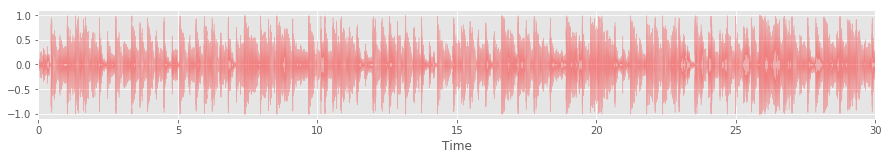

In [30]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y  = y,
                     sr     = sr, 
                     max_sr = 1000, 
                     alpha  = 0.25, 
                     color  = 'red')

In [8]:
print('Signal mean = {:.2f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.2f}'.format(np.std(y)))
print('Signal skewness = {:.2f}'.format(scipy.stats.skew(abs(y))))
print('Signal kurtosis = {:.2f}'.format(scipy.stats.kurtosis(y)))

Signal mean = 0.09
Signal std dev = 0.11
Signal skewness = 1.10
Signal kurtosis = 0.20


ZCR mean = 0.17
ZCR std dev = 0.04


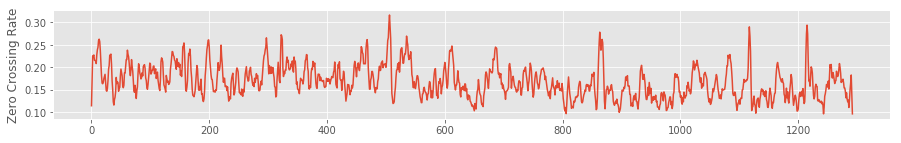

In [9]:
zcr = librosa.feature.zero_crossing_rate(y + 0.0001, frame_length=2048, hop_length=512)[0]
plt.figure(figsize=(15,2))
plt.plot(zcr)
plt.ylabel('Zero Crossing Rate')
print('ZCR mean = {:.2f}'.format(np.mean(zcr)))
print('ZCR std dev = {:.2f}'.format(np.std(zcr)))

RMSE mean = 0.11
RMSE std dev = 0.01


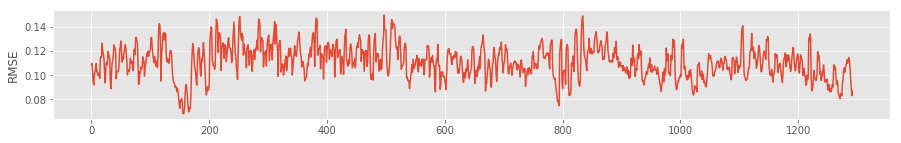

In [10]:
rmse = librosa.feature.rmse(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.2f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.2f}'.format(np.std(rmse)))

Spectral Centroid mean = 2957.09
Spectral Centroid std dev = 358.18


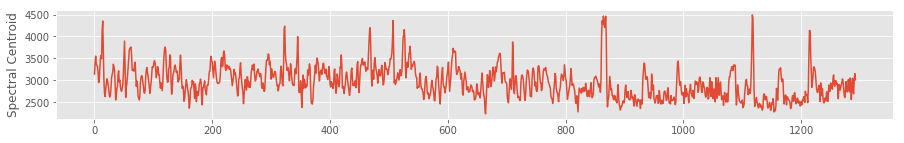

In [11]:
spectral_centroids = librosa.feature.spectral_centroid(y+0.01, sr=sr)[0]
plt.figure(figsize=(15,2))
plt.plot(spectral_centroids)
plt.ylabel('Spectral Centroid')
print('Spectral Centroid mean = {:.2f}'.format(np.mean(spectral_centroids)))
print('Spectral Centroid std dev = {:.2f}'.format(np.std(spectral_centroids)))

Spectral Bandwidth-2 mean = 2464.57
Spectral Bandwidth-2 std dev = 166.22
Spectral Bandwidth-3 mean = 2767.62
Spectral Bandwidth-3 std dev = 152.82
Spectral Bandwidth-4 mean = 3038.54
Spectral Bandwidth-4 std dev = 134.81


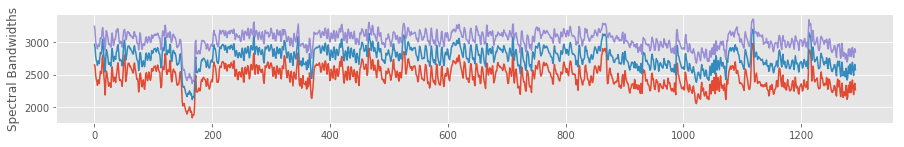

In [12]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=2)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15,2))
plt.plot(spectral_bandwidth_2)
plt.plot(spectral_bandwidth_3)
plt.plot(spectral_bandwidth_4)
plt.ylabel('Spectral Bandwidths')
print('Spectral Bandwidth-2 mean = {:.2f}'.format(np.mean(spectral_bandwidth_2)))
print('Spectral Bandwidth-2 std dev = {:.2f}'.format(np.std(spectral_bandwidth_2)))
print('Spectral Bandwidth-3 mean = {:.2f}'.format(np.mean(spectral_bandwidth_3)))
print('Spectral Bandwidth-3 std dev = {:.2f}'.format(np.std(spectral_bandwidth_3)))
print('Spectral Bandwidth-4 mean = {:.2f}'.format(np.mean(spectral_bandwidth_4)))
print('Spectral Bandwidth-4 std dev = {:.2f}'.format(np.std(spectral_bandwidth_4)))
# Highly Correlated features may cause issues in the model building

Means [21.10850126 13.72814517 15.7618335  14.40866838 15.48395063 15.87993923
 43.07123213]
Std devs [4.46361856 3.38296246 3.75496691 2.49296329 1.99971459 2.26996281
 2.24056382]


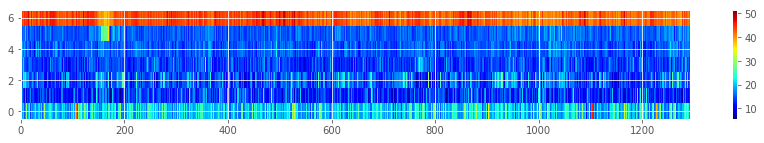

In [13]:
# Frequency cutoff for the first bin `[0, fmin]`
# Subsequent bins will cover `[fmin, 2*fmin]`, `[2*fmin, 4*fmin]
# Bins are on log scale
spectral_contrast = librosa.feature.spectral_contrast(y, sr=sr, n_bands = 6, fmin = 200.0)
plt.figure(figsize=(15,2))
plt.imshow(spectral_contrast, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
print('Means', np.mean(spectral_contrast, axis=1)) # Values are on dB scale
print('Std devs', np.std(spectral_contrast, axis=1))

Spectral Centroid mean = 5799.33
Spectral Centroid std dev = 616.93


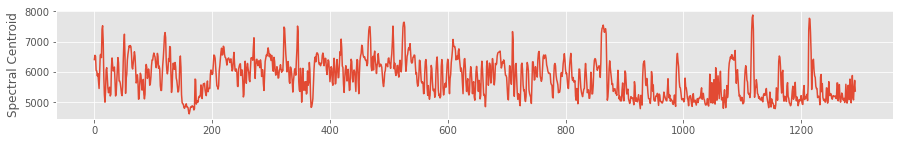

In [14]:
spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr, roll_percent = 0.85)[0]
plt.figure(figsize=(15,2))
plt.plot(spectral_rolloff)
plt.ylabel('Spectral Centroid')
print('Spectral Centroid mean = {:.2f}'.format(np.mean(spectral_rolloff)))
print('Spectral Centroid std dev = {:.2f}'.format(np.std(spectral_rolloff)))

Means [-76.7714537   67.99773777 -11.24468168  76.37576286 -17.46794074
  25.33632708 -17.89357138  20.36639115 -21.40998077  14.21650983
 -15.76415484  12.51373674 -18.49928095  10.82957949 -13.69621318
   4.86615485 -11.97183716   1.64319754  -7.63669186   2.22754474]
Std devs [23.00909293 15.05597845 10.70387458 14.46389631 11.8874814   7.77335446
  8.19778034  7.94940305  6.51519097  6.21300839  5.32799813  4.64779475
  5.39349886  4.80352389  4.6096329   4.56156045  4.39506835  4.61821908
  4.92770758  4.40951802]


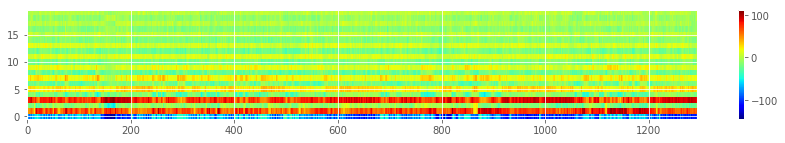

In [15]:
mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)
plt.figure(figsize=(15,2))
plt.imshow(mfccs, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
print('Means', np.mean(mfccs, axis=1)) 
print('Std devs', np.std(mfccs, axis=1))

Means [0.49788907 0.38712545 0.40114651 0.45802697 0.53725751 0.47716055
 0.54248578 0.61988636 0.52446438 0.48231666 0.47732324 0.52220162]
Std devs [0.25774191 0.20855266 0.22500355 0.25932296 0.29417308 0.24126177
 0.24908359 0.28051232 0.25265804 0.26326355 0.24262897 0.26848813]


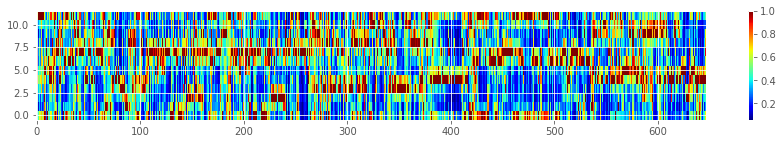

In [16]:
chroma_stft = librosa.feature.chroma_stft(y, sr=sr, hop_length=1024)
plt.figure(figsize=(15,2))
plt.imshow(chroma_stft, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
print('Means', np.mean(chroma_stft, axis=1)) 
print('Std devs', np.std(chroma_stft, axis=1))

Means [0.57056678 0.49909295 0.50840413 0.58474171 0.64287215 0.59488157
 0.63775614 0.65162332 0.60633178 0.55646744 0.56586475 0.63604901]
Std devs [0.20866666 0.19536106 0.21427995 0.22602973 0.25577106 0.19923335
 0.22018927 0.22344009 0.21825427 0.23568599 0.19775884 0.24518357]


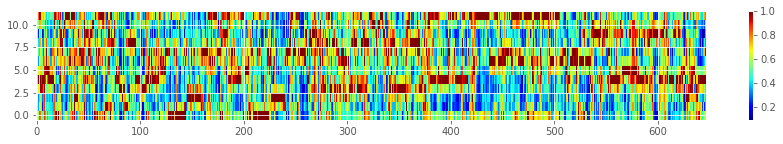

In [17]:
chroma_cqt = librosa.feature.chroma_cqt(y, sr=sr, hop_length=1024)
plt.figure(figsize=(15,2))
plt.imshow(chroma_cqt, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
print('Means', np.mean(chroma_cqt, axis=1)) 
print('Std devs', np.std(chroma_cqt, axis=1))

Means [0.27105944 0.21962171 0.22379336 0.27462893 0.30660551 0.28302349
 0.310206   0.31621399 0.28871173 0.2549439  0.26349869 0.30323633]
Std devs [0.07706477 0.07322134 0.07589607 0.08759805 0.0998357  0.0617016
 0.07309916 0.06645218 0.06496955 0.08964548 0.0616921  0.09162267]


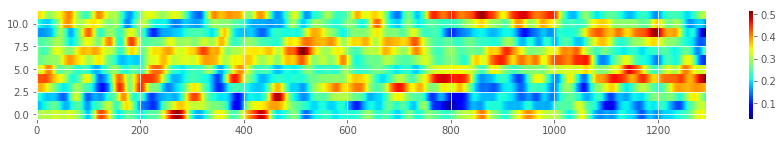

In [18]:
chroma_cens = librosa.feature.chroma_cens(y, sr=sr, hop_length=512)
plt.figure(figsize=(15,2))
plt.imshow(chroma_cens, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
print('Means', np.mean(chroma_cens, axis=1)) 
print('Std devs', np.std(chroma_cens, axis=1))

In [19]:
col_names = ['file_name', 'signal_mean', 'signal_std', 'signal_skew', 'signal_kurtosis', 
             'zcr_mean', 'zcr_std', 'rmse_mean', 'rmse_std', 'tempo',
             'spectral_centroid_mean', 'spectral_centroid_std',
             'spectral_bandwidth_2_mean', 'spectral_bandwidth_2_std',
             'spectral_bandwidth_3_mean', 'spectral_bandwidth_3_std',
             'spectral_bandwidth_4_mean', 'spectral_bandwidth_4_std'] + \
            ['spectral_contrast_' + str(i+1) + '_mean' for i in range(7)] + \
            ['spectral_contrast_' + str(i+1) + '_std' for i in range(7)] + \
            ['spectral_rolloff_mean', 'spectral_rolloff_std'] + \
            ['mfccs_' + str(i+1) + '_mean' for i in range(20)] + \
            ['mfccs_' + str(i+1) + '_std' for i in range(20)] + \
            ['chroma_stft_' + str(i+1) + '_mean' for i in range(12)] + \
            ['chroma_stft_' + str(i+1) + '_std' for i in range(12)] + \
            ['genre']
            
df = pd.DataFrame(columns=col_names)

In [20]:
folder="genres/"
dir_list = sorted(os.listdir(folder))
dir_list

['.DS_Store',
 'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [21]:
dir_list.remove(".DS_Store")

In [22]:
dir_list

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [23]:
files = sorted(os.listdir(folder+"pop/"))

In [24]:
"""
for direc in dir_list:
    for f in tqdm(sorted(os.listdir(folder+direc+"/"))):
        try:
            # Read wav-file
            y, sr = librosa.load(folder+direc+"/"+f, sr = 22050)

            feature_list = [f]

            feature_list.append(np.mean(abs(y)))
            feature_list.append(np.std(y))
            feature_list.append(scipy.stats.skew(abs(y)))
            feature_list.append(scipy.stats.kurtosis(y))

            zcr = librosa.feature.zero_crossing_rate(y + 0.0001, frame_length=2048, hop_length=512)[0]
            feature_list.append(np.mean(zcr))
            feature_list.append(np.std(zcr))

            rmse = librosa.feature.rmse(y + 0.0001)[0]
            feature_list.append(np.mean(rmse))
            feature_list.append(np.std(rmse))

            tempo = librosa.beat.tempo(y, sr=sr)
            feature_list.extend(tempo)

            spectral_centroids = librosa.feature.spectral_centroid(y+0.01, sr=sr)[0]
            feature_list.append(np.mean(spectral_centroids))
            feature_list.append(np.std(spectral_centroids))

            spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=2)[0]
            spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
            spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
            feature_list.append(np.mean(spectral_bandwidth_2))
            feature_list.append(np.std(spectral_bandwidth_2))
            feature_list.append(np.mean(spectral_bandwidth_3))
            feature_list.append(np.std(spectral_bandwidth_3))
            feature_list.append(np.mean(spectral_bandwidth_3))
            feature_list.append(np.std(spectral_bandwidth_3))

            spectral_contrast = librosa.feature.spectral_contrast(y, sr=sr, n_bands = 6, fmin = 200.0)
            feature_list.extend(np.mean(spectral_contrast, axis=1))
            feature_list.extend(np.std(spectral_contrast, axis=1))

            spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr, roll_percent = 0.85)[0]
            feature_list.append(np.mean(spectral_rolloff))
            feature_list.append(np.std(spectral_rolloff))

            mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)
            feature_list.extend(np.mean(mfccs, axis=1))
            feature_list.extend(np.std(mfccs, axis=1))

            chroma_stft = librosa.feature.chroma_stft(y, sr=sr, hop_length=1024)
            feature_list.extend(np.mean(chroma_stft, axis=1))
            feature_list.extend(np.std(chroma_stft, axis=1))

            feature_list[1:] = np.round(feature_list[1:], decimals=3)
            
            feature_list.append(direc)

        except:
            pass

        df = df.append(pd.DataFrame(feature_list, index=col_names).transpose(), ignore_index=True)

    # Save file
    df.to_csv('df_features.csv', index=False)
    """

'\nfor direc in dir_list:\n    for f in tqdm(sorted(os.listdir(folder+direc+"/"))):\n        try:\n            # Read wav-file\n            y, sr = librosa.load(folder+direc+"/"+f, sr = 22050)\n\n            feature_list = [f]\n\n            feature_list.append(np.mean(abs(y)))\n            feature_list.append(np.std(y))\n            feature_list.append(scipy.stats.skew(abs(y)))\n            feature_list.append(scipy.stats.kurtosis(y))\n\n            zcr = librosa.feature.zero_crossing_rate(y + 0.0001, frame_length=2048, hop_length=512)[0]\n            feature_list.append(np.mean(zcr))\n            feature_list.append(np.std(zcr))\n\n            rmse = librosa.feature.rmse(y + 0.0001)[0]\n            feature_list.append(np.mean(rmse))\n            feature_list.append(np.std(rmse))\n\n            tempo = librosa.beat.tempo(y, sr=sr)\n            feature_list.extend(tempo)\n\n            spectral_centroids = librosa.feature.spectral_centroid(y+0.01, sr=sr)[0]\n            feature_list.ap

In [5]:
df = pd.read_csv("df_features.csv")

In [6]:
df[df.genre=="reggae"]

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,genre
800,reggae.00000.au,0.074,0.103,1.686,1.912,0.098,0.036,0.094,0.042,123.047,...,0.252,0.355,0.282,0.366,0.227,0.264,0.337,0.229,0.257,reggae
801,reggae.00001.au,0.064,0.091,2.960,6.735,0.064,0.037,0.082,0.040,151.999,...,0.200,0.180,0.317,0.341,0.255,0.349,0.238,0.298,0.211,reggae
802,reggae.00002.au,0.070,0.102,2.494,4.900,0.075,0.042,0.092,0.043,103.359,...,0.255,0.359,0.297,0.333,0.271,0.229,0.240,0.233,0.361,reggae
803,reggae.00003.au,0.075,0.105,1.809,2.699,0.085,0.063,0.094,0.046,151.999,...,0.289,0.335,0.310,0.311,0.233,0.268,0.376,0.270,0.281,reggae
804,reggae.00004.au,0.078,0.114,1.872,2.822,0.085,0.049,0.101,0.052,123.047,...,0.250,0.299,0.283,0.321,0.283,0.309,0.349,0.275,0.278,reggae
805,reggae.00005.au,0.080,0.112,1.465,1.446,0.073,0.042,0.100,0.050,151.999,...,0.343,0.299,0.319,0.286,0.361,0.217,0.208,0.267,0.260,reggae
806,reggae.00006.au,0.085,0.117,1.558,1.535,0.061,0.051,0.105,0.051,151.999,...,0.267,0.334,0.221,0.297,0.210,0.314,0.346,0.240,0.293,reggae
807,reggae.00007.au,0.071,0.099,1.819,2.365,0.074,0.045,0.091,0.039,151.999,...,0.331,0.282,0.339,0.247,0.292,0.255,0.267,0.346,0.273,reggae
808,reggae.00008.au,0.081,0.113,1.640,1.871,0.069,0.046,0.102,0.048,95.703,...,0.330,0.235,0.267,0.250,0.360,0.258,0.294,0.318,0.265,reggae
809,reggae.00009.au,0.068,0.097,1.860,2.924,0.061,0.050,0.087,0.043,161.499,...,0.324,0.238,0.265,0.209,0.320,0.356,0.334,0.314,0.251,reggae


Text(0.5, 0, 'Genre')

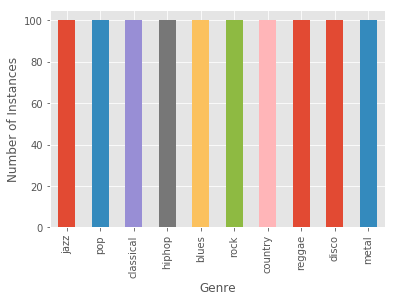

In [7]:
df["genre"].value_counts().plot(kind='bar')
plt.ylabel("Number of Instances")
plt.xlabel("Genre")

In [8]:
lb = LabelEncoder()

In [9]:
df["genre"] = lb.fit_transform(df["genre"])

In [10]:
label_dict = {'blues':0,
              'classical':1,
              'country':2,
              'disco':3,
              'hiphop':4,
              'jazz':5,
              'metal':6,
              'pop':7,
              'reggae':8,
              'rock':9
             }

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(one_hot_true,pred_probs)))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

    skplt.metrics.plot_roc(y_test, pred_probs, figsize=(12,8))


In [12]:
df.iloc[:,-1]

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
970    9
971    9
972    9
973    9
974    9
975    9
976    9
977    9
978    9
979    9
980    9
981    9
982    9
983    9
984    9
985    9
986    9
987    9
988    9
989    9
990    9
991    9
992    9
993    9
994    9
995    9
996    9
997    9
998    9
999    9
Name: genre, Length: 1000, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=0.2, random_state=42, stratify=df.iloc[:,-1]) 

In [14]:
y_test.value_counts()

9    20
8    20
7    20
6    20
5    20
4    20
3    20
2    20
1    20
0    20
Name: genre, dtype: int64

Test Set Accuracy =  0.42
Test Set F-score =  0.40
ROC AUC = 0.818
Confusion matrix, without normalization
[[10  1  2  0  1  1  1  0  3  1]
 [ 1 16  2  0  0  1  0  0  0  0]
 [ 6  0  9  1  1  2  0  1  0  0]
 [ 1  0  4  7  2  0  1  4  0  1]
 [ 0  0  0  3  4  0  3  4  5  1]
 [ 4  3  4  0  0  6  0  2  1  0]
 [ 3  0  1  3  0  1 12  0  0  0]
 [ 0  0  4  2  2  0  0 12  0  0]
 [ 0  0  3  1  3  0  0  3  9  1]
 [ 4  1  3  3  1  1  2  2  3  0]]


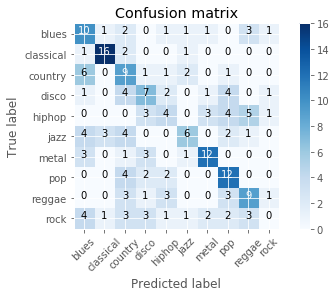

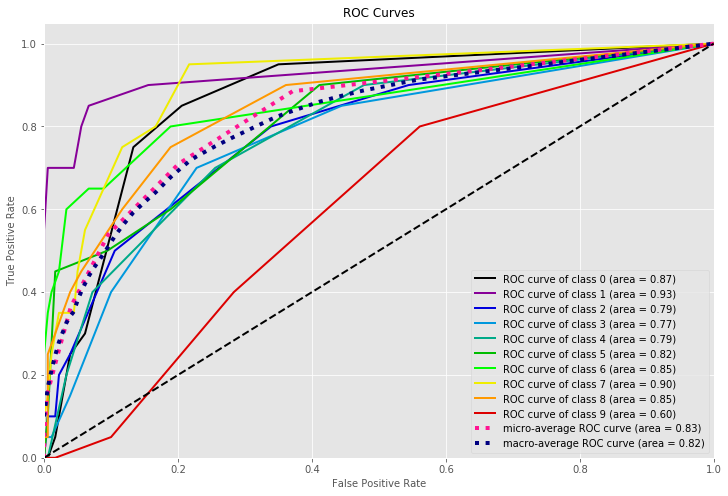

In [44]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict_proba(X_test)
display_results(y_test, y_pred)

In [33]:
rf = RandomForestClassifier()

In [34]:
rf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
y_pred = rf.predict_proba(X_test)

Test Set Accuracy =  0.59
Test Set F-score =  0.58
ROC AUC = 0.884
Confusion matrix, without normalization
[[12  0  3  0  0  1  0  0  4  0]
 [ 0 18  1  0  0  1  0  0  0  0]
 [ 6  0  9  0  0  2  0  0  2  1]
 [ 0  1  2 11  4  0  0  1  1  0]
 [ 0  0  1  3 13  0  1  0  2  0]
 [ 3  1  0  0  0 16  0  0  0  0]
 [ 1  0  0  1  1  0 15  0  1  1]
 [ 0  0  1  1  1  1  0 15  1  0]
 [ 1  1  1  3  3  0  1  1  8  1]
 [ 3  1  5  1  2  3  3  0  0  2]]


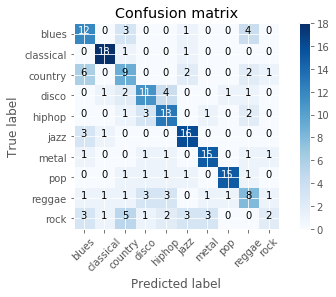

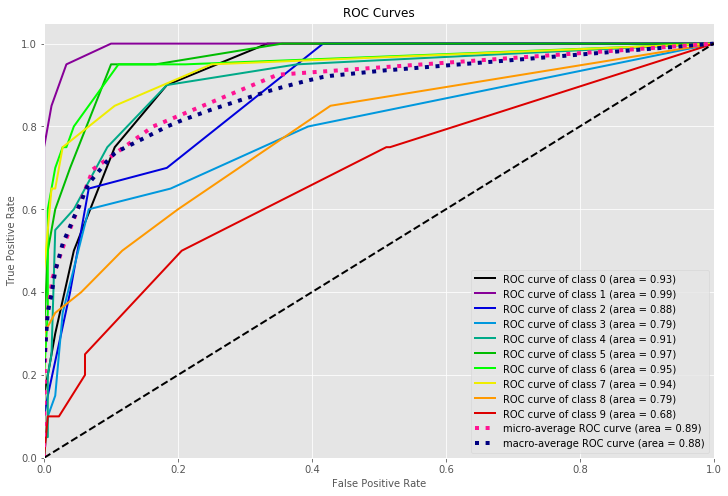

In [36]:
display_results(y_test, y_pred)

In [71]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 50, 80, 100],
    'max_features': ["auto","log2",None],
    'min_samples_leaf': [3, 5, 7, 9],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [38]:
#grid_search.fit(X_train,y_train)

In [39]:
#grid_search.best_params_ 
'''
{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}
'''

"\n{'bootstrap': True,\n 'max_depth': 20,\n 'max_features': 'log2',\n 'min_samples_leaf': 3,\n 'min_samples_split': 8,\n 'n_estimators': 300}\n"

In [40]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [15, 20, 25, 30],
    'max_features': ["auto","log2",None],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [6, 7, 8, 9],
    'n_estimators': [300, 350, 400]
}

In [41]:
#grid_search.fit(X_train,y_train)
#grid_search.best_params_

In [45]:
rf = RandomForestClassifier(bootstrap = True,
 max_depth=20,
 max_features = 'log2',
 min_samples_leaf = 3,
 min_samples_split = 8,
 n_estimators = 300, random_state=42)

In [46]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Test Set Accuracy =  0.72
Test Set F-score =  0.71
ROC AUC = 0.955
Confusion matrix, without normalization
[[17  0  2  0  0  0  0  0  1  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 2  1 16  0  0  0  0  0  1  0]
 [ 0  0  1  8  4  1  0  4  1  1]
 [ 1  0  0  1 16  0  1  1  0  0]
 [ 1  1  0  0  0 17  0  1  0  0]
 [ 0  0  0  1  1  0 16  0  1  1]
 [ 0  0  1  1  1  1  0 15  1  0]
 [ 0  0  0  3  4  1  0  0 11  1]
 [ 1  0  2  0  0  2  2  1  3  9]]


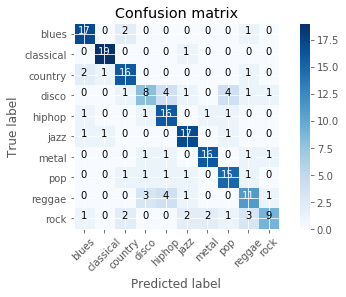

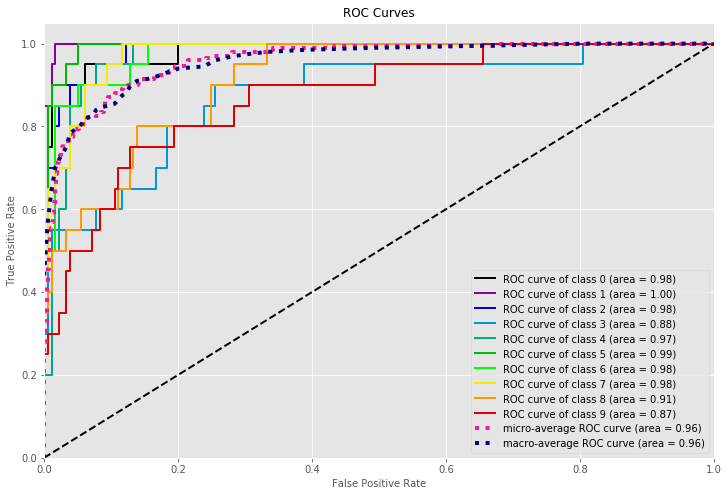

In [45]:
rf.fit(X_train,y_train)
y_pred = rf.predict_proba(X_test)
display_results(y_test, y_pred)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test Set Accuracy =  0.77
Test Set F-score =  0.76
ROC AUC = 0.960
Confusion matrix, without normalization
[[19  0  0  0  0  0  1  0  0  0]
 [ 0 18  1  0  0  1  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  2  4]
 [ 1  0  2 12  2  0  1  2  0  0]
 [ 0  0  0  0 19  0  0  0  1  0]
 [ 0  1  1  0  0 16  0  0  1  1]
 [ 1  0  0  0  1  0 17  0  0  1]
 [ 0  0  0  2  0  0  0 17  1  0]
 [ 0  0  1  1  1  0  0  0 16  1]
 [ 2  0  3  2  0  1  1  4  1  6]]


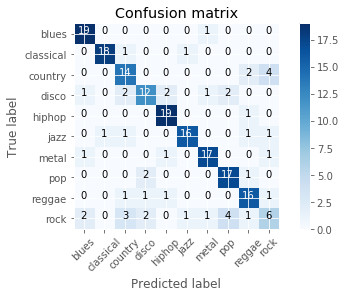

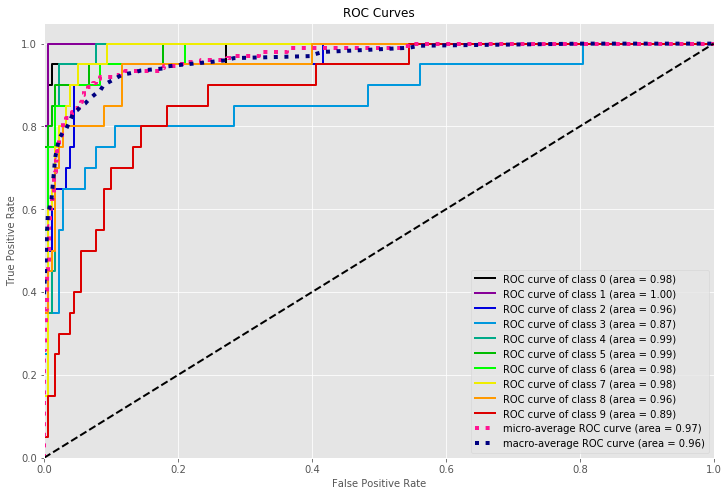

In [68]:
lr = LogisticRegression(random_state=42, multi_class='auto')
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)
display_results(y_test, y_pred)

In [69]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [70]:
clf = GridSearchCV(lr, hyperparameters, cv=5, n_jobs = -1, verbose = 2)

In [71]:
clf.fit(X_train,y_train)
clf.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 1.0, 'penalty': 'l1'}

Test Set Accuracy =  0.78
Test Set F-score =  0.77
ROC AUC = 0.964
Confusion matrix, without normalization
[[19  0  0  0  0  0  1  0  0  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  2  3]
 [ 0  0  2 12  4  0  0  2  0  0]
 [ 0  0  0  1 18  0  0  0  1  0]
 [ 0  2  0  0  0 17  0  0  0  1]
 [ 3  0  0  0  2  0 15  0  0  0]
 [ 0  0  0  2  0  0  0 17  1  0]
 [ 0  0  1  1  1  0  0  0 16  1]
 [ 1  0  3  2  1  1  1  3  1  7]]


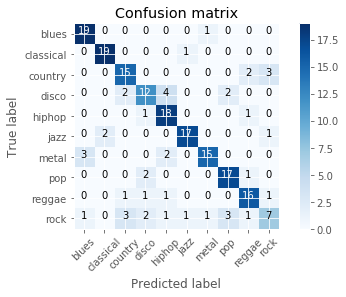

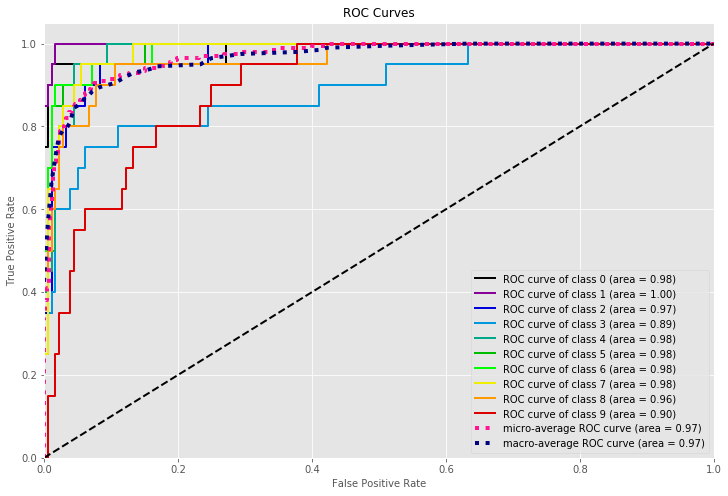

In [72]:
gd = clf.best_estimator_
y_pred = gd.predict_proba(X_test)
display_results(y_test, y_pred)

Test Set Accuracy =  0.78
Test Set F-score =  0.77
ROC AUC = 0.961
Confusion matrix, without normalization
[[16  0  2  0  0  0  0  0  2  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  1]
 [ 0  0  2 12  4  0  0  0  1  1]
 [ 0  0  0  3 15  0  1  0  1  0]
 [ 1  0  0  0  0 18  0  0  0  1]
 [ 1  0  0  1  1  0 16  0  0  1]
 [ 0  0  1  1  0  0  0 18  0  0]
 [ 0  0  0  1  3  0  0  1 14  1]
 [ 2  0  3  2  2  2  1  0  0  8]]


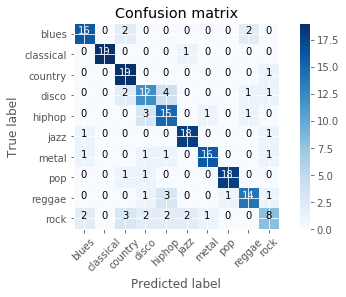

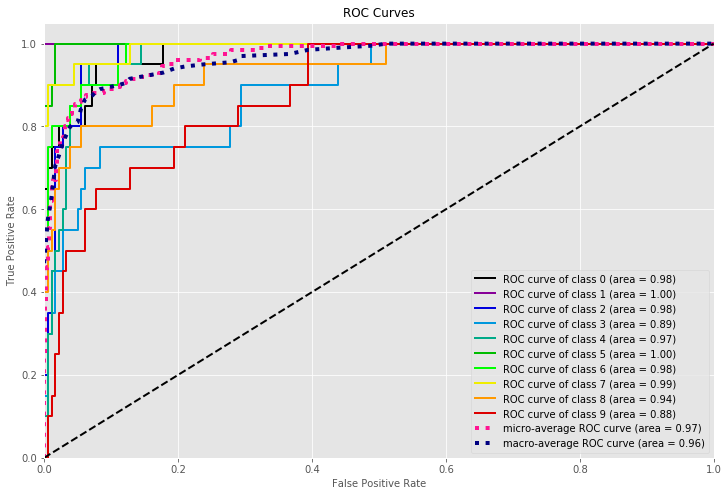

In [69]:
xgb = xgboost.XGBClassifier(random_state=42)
xgb.fit(X_train,y_train)
y_pred = xgb.predict_proba(X_test)
display_results(y_test, y_pred)

In [72]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'learning_rate':[0.1,0.005,0.001],
 'n_estimators':[100,500,1000]   
}
gsearch1 = GridSearchCV(estimator = xgboost.XGBClassifier( learning_rate =0.1, n_estimators=106, max_depth=10,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=42), 
 param_grid = param_test1,n_jobs=-1,iid=False, cv=5, verbose=True)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 39.3min finished


({'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 1000},
 0.75375)

Test Set Accuracy =  0.80
Test Set F-score =  0.79
ROC AUC = 0.974
Confusion matrix, without normalization


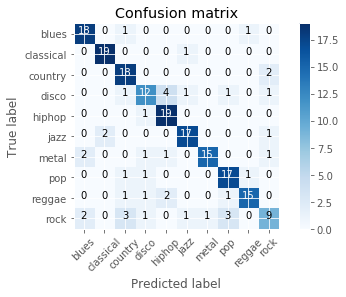

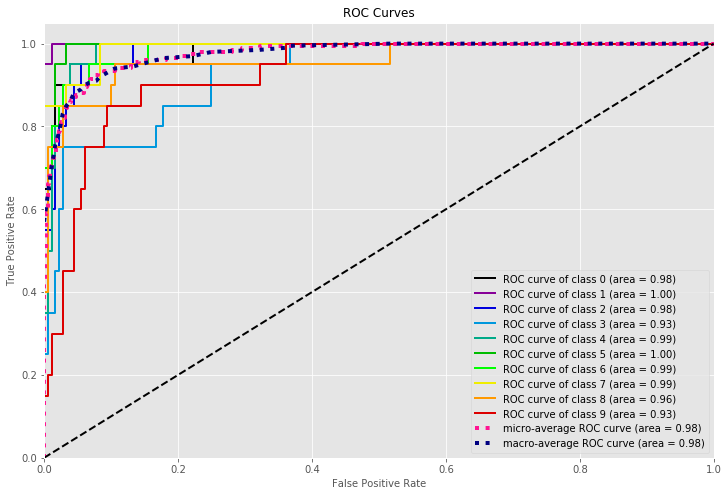

In [49]:
xgb = xgboost.XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=3, 
            min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=42)
xgb.fit(X_train,y_train)
y_pred = xgb.predict_proba(X_test)
display_results(y_test, y_pred)

Test Set Accuracy =  0.80
Test Set F-score =  0.79
ROC AUC = 0.974
Normalized confusion matrix


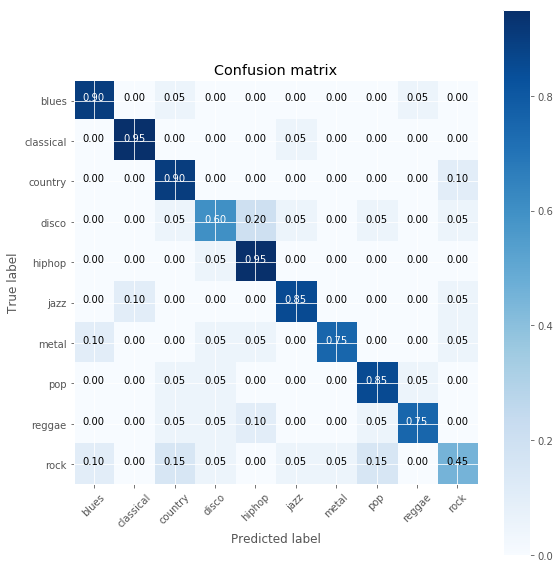

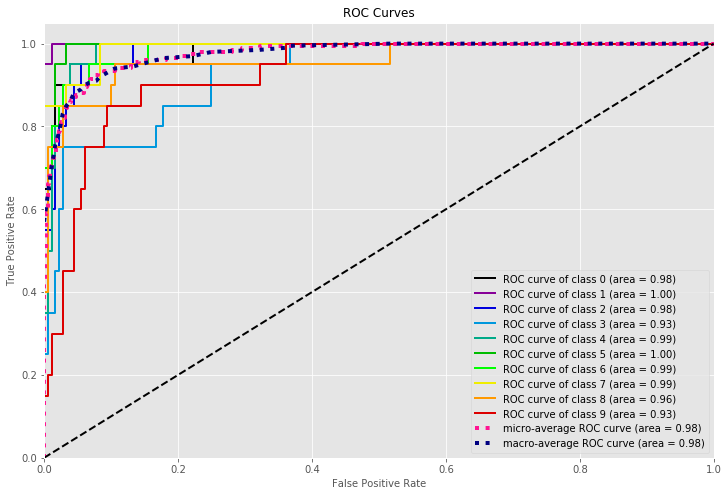

In [55]:
display_results(y_test, y_pred)

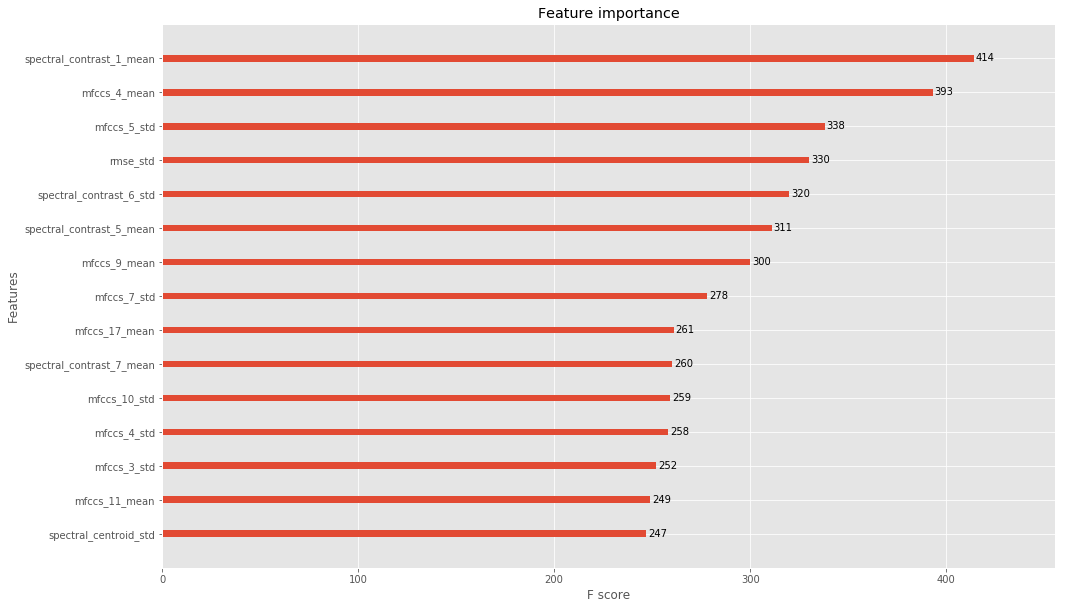

In [65]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
xgboost.plot_importance(xgb, ax=ax, max_num_features=15)

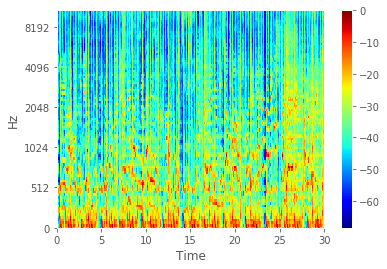

In [32]:
from matplotlib import cm
M = librosa.feature.melspectrogram(y, sr, fmax = sr/2, n_fft=2048, hop_length=512, 
                                   n_mels = 96, power = 2) # Power = 2 refers to squared amplitude 
                                                           # Hanning window by default
log_power = librosa.power_to_db(M, ref=np.max)# Covert to dB (log) scale
librosa.display.specshow(log_power, x_axis='time', y_axis='mel', cmap=cm.jet)
plt.colorbar()

In [58]:
preds = xgb.predict(X_test)
cm = confusion_matrix(preds, y_test)

Normalized confusion matrix


<Figure size 576x576 with 0 Axes>

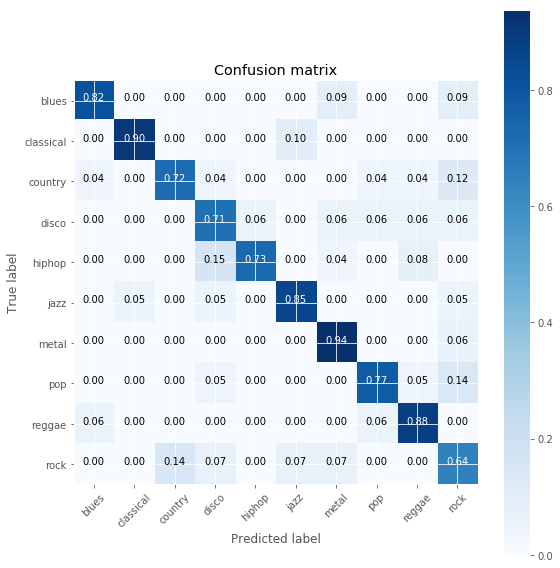

In [60]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, classes=label_dict.keys(), normalize=True)